In [48]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=0675346bab02694c278ec3491c1fce319356c8c809b267af573bc2cff09d4e56
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [1]:
import os
import random
from pathlib import Path
import sys

import cv2
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer, AutoModel, MMBTForClassification, MMBTConfig, AutoConfig,
    Trainer, TrainingArguments,
)
import transformers
from torchvision.io import read_image
from torchvision.models import ResNet152_Weights, resnet152
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore', UserWarning)

sys.path.append('../')
from src.data.prepare import load_base_df

In [2]:
# データのロード
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

## 学習用データのラベル分布確認

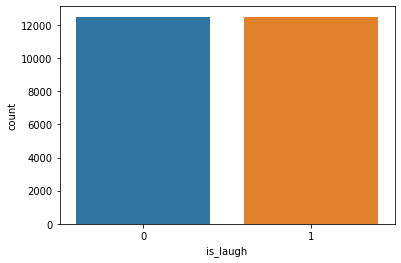

In [5]:
sns.countplot(data=train_df, x='is_laugh')
plt.show()

## テキスト長分布確認

<AxesSubplot:xlabel='is_laugh', ylabel='text_len'>

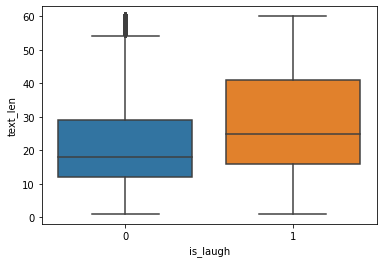

In [7]:
# 文章長の分布確認
train_df['text_len'] = train_df['text'].str.len()
sns.boxplot(data=train_df, x='is_laugh', y='text_len')

<AxesSubplot:xlabel='is_laugh', ylabel='encoded_seq_len'>

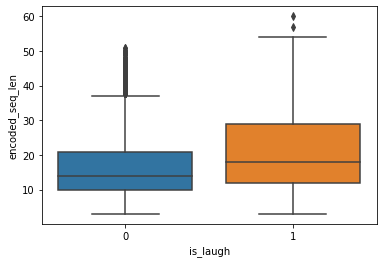

In [38]:
# tokenizerによるtoken長の分布確認
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
encoded_len_list = []
for _, row in train_df.iterrows():
    encoded = tokenizer.encode(row['text'])
    encoded_len_list.append(len(encoded))
train_df['encoded_seq_len'] = encoded_len_list
sns.boxplot(data=train_df, x='is_laugh', y='encoded_seq_len')

## 画像にテキスト貼り付け

In [3]:
def show_or_save_fig(img, txt=None, dst=None):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if txt:
        plt.title(txt)
    if not dst:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(dst, bbox_inches='tight')
        plt.cla()
        plt.clf()
        plt.close('all')

In [4]:
DST_DIR = Path('../plots/dataset_with_txt')
TRAIN_DST_DIR = DST_DIR / 'train'
TEST_DST_DIR = DST_DIR / 'test'

In [4]:
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = cv2.imread(row['img_path'])
    save_file_name = row['odai_photo_file_name']
    dst_dir = TRAIN_DST_DIR / 'laugh' if row['is_laugh'] else TRAIN_DST_DIR / 'not_laugh'
    if not dst_dir.exists():
        dst_dir.mkdir(parents=True)
    dst = dst_dir / save_file_name
    if dst.exists():
        continue
    txt = f"{row['text']}({row['is_laugh']})"
    show_or_save_fig(img, txt, dst)

 64% 15890/24962 [37:44<24:15,  6.23it/s] Font 'rm' does not have a glyph for '\u52dd' [U+52dd], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u8ca0' [U+8ca0], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u3067' [U+3067], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u56de' [U+56de], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u52dd' [U+52dd], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u8ca0' [U+8ca0], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u3067' [U+3067], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u56de' [U+56de], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u52dd' [U+52dd], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u8ca0' [U+8ca0], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\u3067' [U+3067], substituting 

In [7]:
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img = cv2.imread(row['img_path'])
    save_file_name = row['odai_photo_file_name']
    if not TEST_DST_DIR.exists():
        TEST_DST_DIR.mkdir(parents=True)
    dst = TEST_DST_DIR / save_file_name
    if dst.exists():
        continue
    txt = row['text']
    show_or_save_fig(img, txt, dst)

100% 6000/6000 [14:14<00:00,  7.02it/s]
